In [1]:
import sys
sys.path.append('../')
from FlowVN import *
sys.path.append('../../')
from CMRx4DFlowMaskGeneration import *
from Utils import *
from einops import rearrange
import matplotlib.pyplot as plt


Train FlowVN Model

In [2]:
# ! nohup python -u main.py --mode train --loss supervised --network FlowVN --features_in 1 --D_size 5 --T_size 15 --num_act_weights 71 --features_out 8 --kernel_size 5 --num_stages 10 --epoch 50 --lr 0.0001 --batch_size 1 --act linear_flowvn --devices 0 1 2 > train_flowvn.log 2>&1

In [4]:
import hdf5storage

data = load_mat('/mnt/nas/nas3/openData/rawdata/4dFlow/ChallengeData/DemoData/kdata_ktGaussian10.mat', 'kdata_ktGaussian')

Test By FlowVN Model

In [15]:
weight_path = '../FlowVN/weights/3-epochepoch=015.ckpt'
R = 10
!python ../FlowVN/main.py --mode test \
  --ckpt_path {weight_path} \
  --input '/mnt/nas/nas3/openData/rawdata/4dFlow/ChallengeData/DemoData/' \
  --network FlowVN --features_in 1 --T_size 15 --features_out 8 --act linear_flowvn\
  --kernel_size 5 --num_stages 10 --loss supervised \
  --save_dir '/mnt/nas/nas3/openData/rawdata/4dFlow/ChallengeData/' --usrate 10 --device 0

----------------- Options ---------------
                   D_size: 1                             
                   T_size: 15                            	[default: 5]
                      act: linear_flowvn                 	[default: linear]
               batch_size: 1                             
                ckpt_path: ../FlowVN/weights/3-epochepoch=015.ckpt	[default: None]
                  devices: [0]                           
                    epoch: 100                           
                 exp_loss: False                         
              features_in: 1                             
             features_out: 8                             	[default: 24]
               grad_check: False                         
                     grid: 0.25                          
              in_base_dir: None                          
                    input: /mnt/nas/nas3/openData/rawdata/4dFlow/ChallengeData/DemoData/	[default: ]
              kernel_size: 5     

Results Comparison

In [13]:
# Read one subject/case from a directory containing the corresponding .mat files
data_dir = '/mnt/nas/nas3/openData/rawdata/4dFlow/ChallengeData/DemoData'

# `load_mat` takes the .mat file path and variable name (`key`) as input.
# It returns a lazy HDF5-like handle (h5py-style): data is not loaded into memory
# until you index it.
kdata_full = load_mat(data_dir + '/kdata_full.mat', key='kdata_full')
coilmap    = load_mat(data_dir + '/coilmap.mat',    key='coilmap')
segmask    = load_mat(data_dir + '/segmask.mat',    key='segmask')
params     = read_params_csv(data_dir + '/params.csv')

# Use [()] to materialize the entire dataset into RAM as a NumPy array.
kdata_full = kdata_full[()]
coilmap    = coilmap[()]
segmask    = segmask[()]

Nv, Nt, Nc, SPE, PE, FE = kdata_full.shape

VENC = params['VENC']
VOrder = params['venc_order']
img = np.sum(k2i_numpy(kdata_full, ax=[-1, -2, -3]) * np.conj(coilmap), axis=-4)

In [16]:
# Load COO representation and reconstruct dense array from compressed .npz file
R = 10
img_vn_masked = load_coo_npz(f"{data_dir}/img_ktGaussian{R}.npz", as_dense=True)

In [17]:
# complex -> (mag, flow)
mag_gt, flow_gt = complex2magflow(img, venc=np.array(VENC))
mag_vn, flow_vn = complex2magflow(img_vn_masked, venc=np.array(VENC))

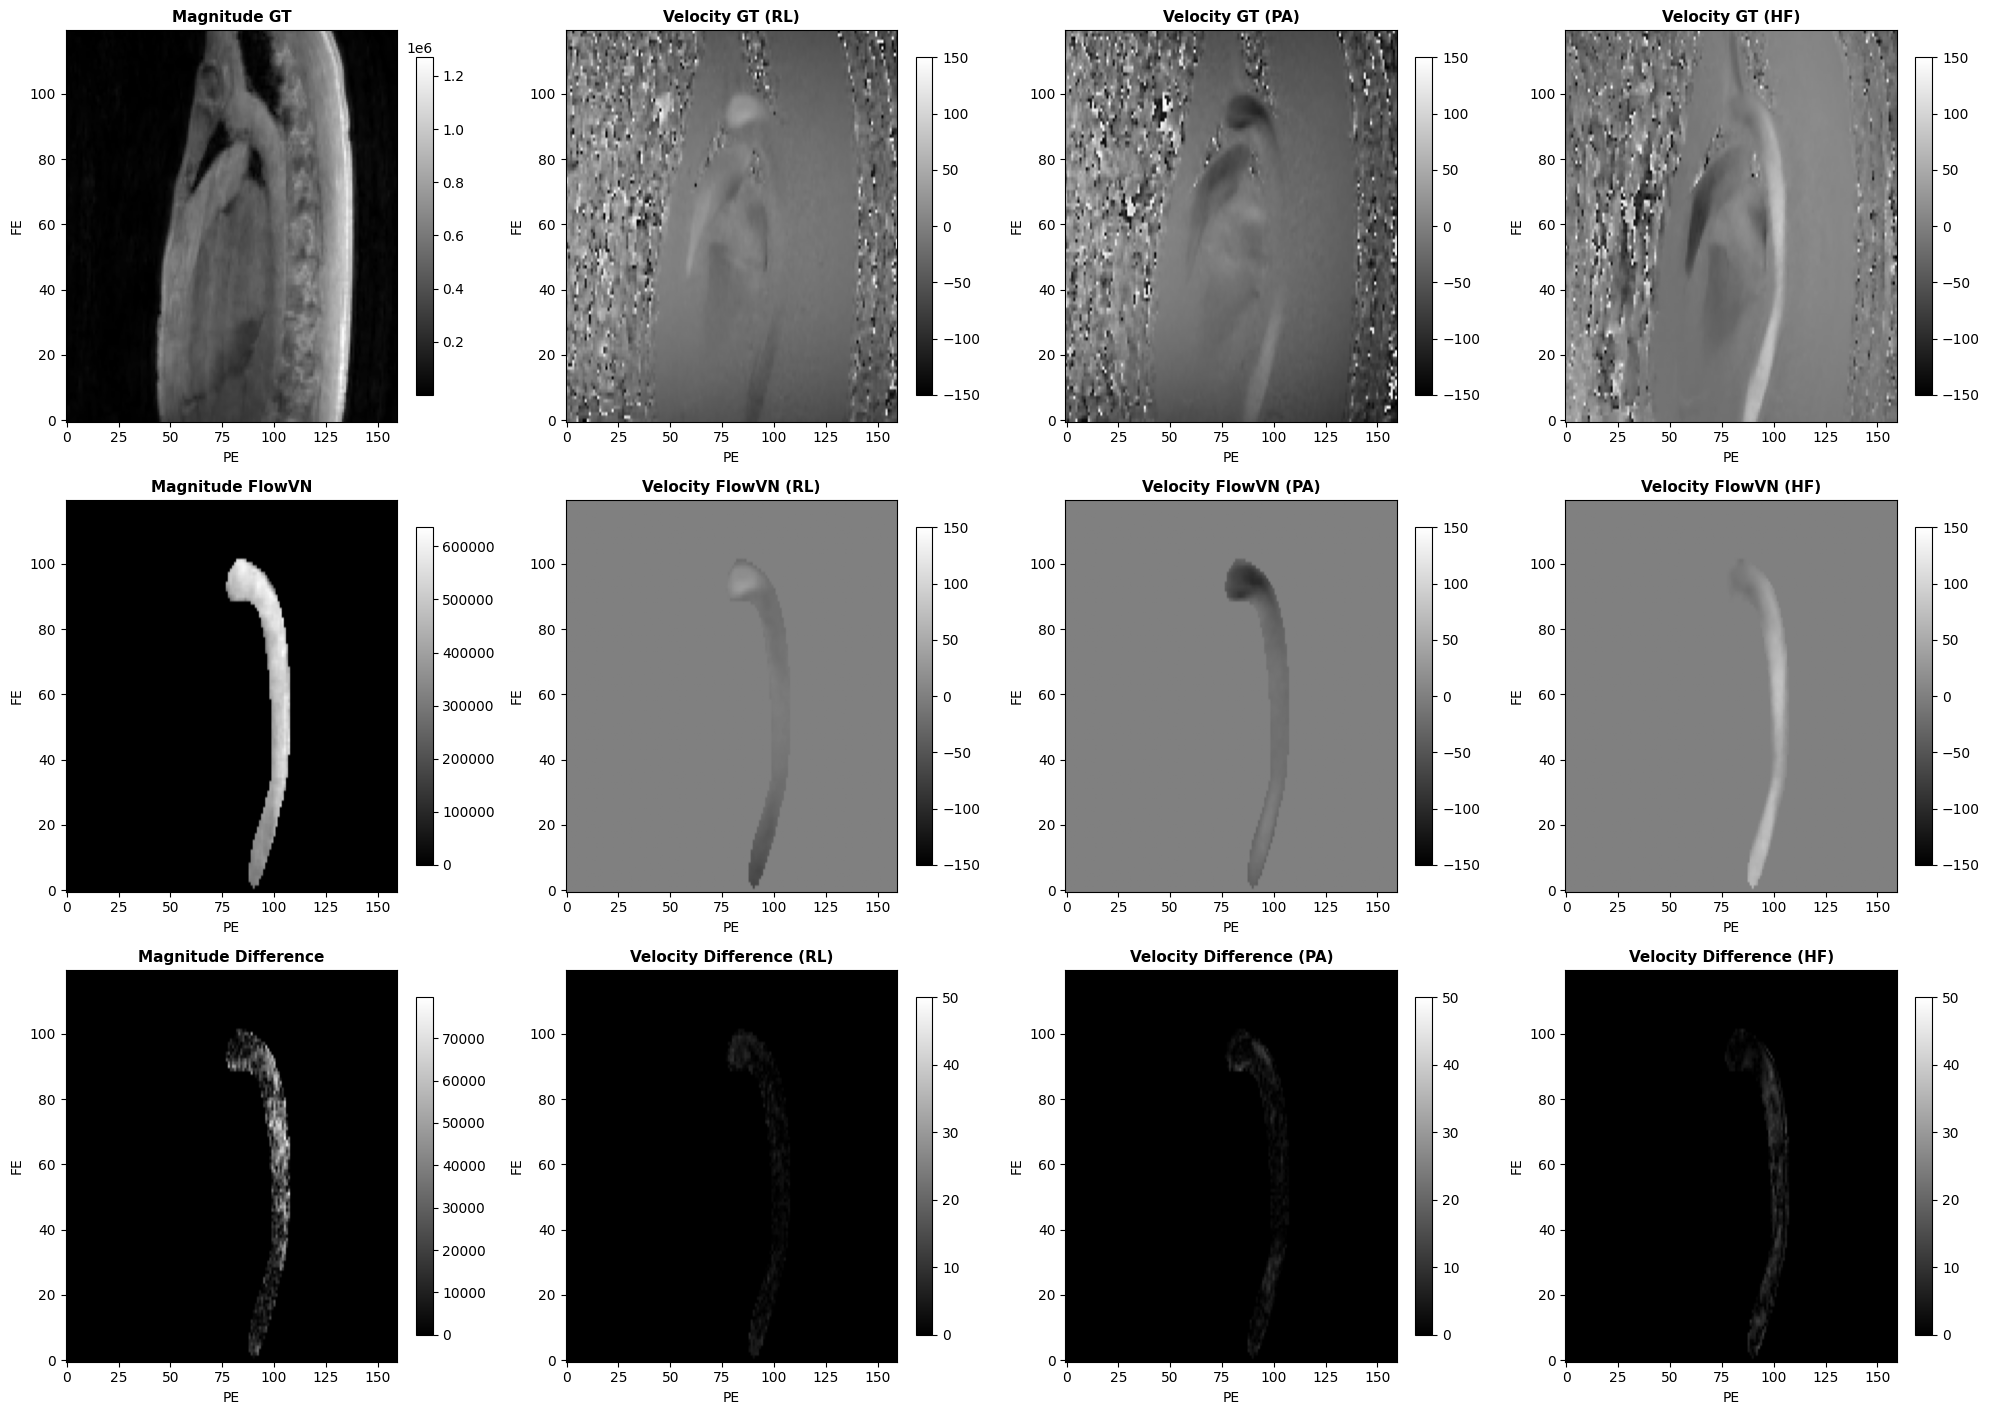

In [18]:
# shapes: (Nv, Nt, SPE, PE, FE)
showz = 14  # SPE index
showt = 1   # Nt index
showv = 0   # magnitude uses this v-index when Nv>1

row, col = 3, 4
fig, axes = plt.subplots(row, col, figsize=(20, 15), constrained_layout=False)

# ---------------- Row 1: GT ----------------
ax = axes[0, 0]
im = ax.imshow(
    np.abs(mag_gt[showv, showt, showz]).T,
    cmap="gray", origin="lower", aspect="auto"
)
ax.set_title("Magnitude GT", fontsize=11, fontweight="bold")
ax.set_ylabel("FE"); ax.set_xlabel("PE")
fig.colorbar(im, ax=ax, fraction=0.046)

for i in range(3):
    ax = axes[0, i + 1]
    img2d = flow_gt[i, showt, showz].T.astype(np.float32)  # no segmask for velocity
    im = ax.imshow(
        img2d,
        cmap="gray", origin="lower", aspect="auto",
        vmin=-VENC[i], vmax=VENC[i]
    )
    ax.set_title(f"Velocity GT ({VOrder[i]})", fontsize=11, fontweight="bold")
    ax.set_ylabel("FE"); ax.set_xlabel("PE")
    fig.colorbar(im, ax=ax, fraction=0.046)

# ---------------- Row 2: CSLLR ----------------
ax = axes[1, 0]
im = ax.imshow(
    np.abs(mag_vn[showv, showt, showz]).T,
    cmap="gray", origin="lower", aspect="auto"
)
ax.set_title("Magnitude FlowVN", fontsize=11, fontweight="bold")
ax.set_ylabel("FE"); ax.set_xlabel("PE")
fig.colorbar(im, ax=ax, fraction=0.046)

for i in range(3):
    ax = axes[1, i + 1]
    img2d = flow_vn[i, showt, showz].T.astype(np.float32)  # no segmask for velocity
    im = ax.imshow(
        img2d,
        cmap="gray", origin="lower", aspect="auto",
        vmin=-VENC[i], vmax=VENC[i]
    )
    ax.set_title(f"Velocity FlowVN ({VOrder[i]})", fontsize=11, fontweight="bold")
    ax.set_ylabel("FE"); ax.set_xlabel("PE")
    fig.colorbar(im, ax=ax, fraction=0.046)

# ---------------- Row 3: Difference maps ----------------
# Magnitude difference, masked
mag_diff = np.abs(np.abs(mag_vn) - np.abs(mag_gt))[showv, showt, showz]
ax = axes[2, 0]
im = ax.imshow(
    (mag_diff * segmask[showz]).T,
    cmap="gray", origin="lower", aspect="auto"
)
ax.set_title("Magnitude Difference", fontsize=11, fontweight="bold")
ax.set_ylabel("FE"); ax.set_xlabel("PE")
fig.colorbar(im, ax=ax, fraction=0.046)

# Velocity difference, masked
for i in range(3):
    ax = axes[2, i + 1]
    flow_diff = np.abs(flow_vn - flow_gt)[i, showt, showz] * segmask[showz]
    im = ax.imshow(
        flow_diff.T.astype(np.float32),
        cmap="gray", origin="lower", aspect="auto",
        vmin=0, vmax=VENC[i] / 3
    )
    ax.set_title(f"Velocity Difference ({VOrder[i]})", fontsize=11, fontweight="bold")
    ax.set_ylabel("FE"); ax.set_xlabel("PE")
    fig.colorbar(im, ax=ax, fraction=0.046)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()